In [108]:
import pandas as pd
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as pyplot
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import nltk
import re
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
import string
from wordcloud import STOPWORDS

## Exploratory data analysis


Cette EDA est faite sur les textes bruts pour identifier les patterns initiaux. Le nettoyage sera fait dans un second temps.

# Objectif :

Comprendre nos données

Développer une première stratégie de modélisation 

# Résumé : 


---

## 1. Analyse de forme

### Dimensions et structure
- **Taille du jeu de données** : `7613 lignes × 5 colonnes`
- **Variable cible** : `target` (0 = non-catastrophe, 1 = catastrophe)
- **Type de variables** :
  - **Qualitatives** : `text`, `location`, `keyword`
  - **Quantitatives** (dérivées du texte) : `char_count`, `word_count`, etc.

---

### Valeurs manquantes

| Variable   | % de valeurs manquantes | Nb de valeurs uniques (non-nulles) |
|------------|--------------------------|------------------------------------|
| `location` | 33.27%                   | 3341                               |
| `keyword`  | 0.80%                    | 221                                |

`keyword` est bien renseignée et exploitable. 
`location` présente 1/3 de valeurs manquantes. Attention

---

## 2. Analyse de la variable cible (`target`)

| Classe     | Proportion |
|------------|------------|
| Non-catastrophe (`target = 0`) | 57.03% |
| Catastrophe (`target = 1`)     | 42.97% |

Suppression de 52 doublons.
Préconisation d'équilibrer les classes.

---

## 3. Signification des variables 


| Variable             | Description technique                                      |
|----------------------|------------------------------------------------------------|
| `keyword`            | Mot-clé extrait ou attribué au tweet                       |
| `location`           | Localisation déclarée par l’utilisateur                    |
| `text`               | Contenu brut du tweet                                      |
| `target`             | Indicateur binaire (0 = non urgent, 1 = urgent)            |
| `presence_location`  | Présence ou absence d’une localisation (1/0)               |
| `presence_keyword`   | Présence ou absence d’un mot-clé (1/0)                     |
| `length`             | Longueur brute du texte (nombre de caractères, espaces compris) |
| `char_count`         | Nombre total de caractères (hors ponctuations ?)           |
| `word_count`         | Nombre total de mots                                       |
| `stopword_count`     | Nombre de stopwords dans le tweet             |
| `unique_word_count`  | Nombre de mots distincts dans le tweet                     |
| `url_count`          | Nombre d’URLs présentes dans le tweet                      |
| `mean_word_length`   | Longueur moyenne des mots                                  |
| `punctuation_count`  | Nombre de signes de ponctuation                            |
| `hashtag_count`      | Nombre de hashtags présents (#)                            |
| `mention_count`      | Nombre de mentions (@utilisateur)                          |


---

## 4. Analyse des variables textuelles choisis

| Variable            | Moyenne (0) | Moyenne (1) | Observation |
|---------------------|-------------|-------------|-------------|
| `char_count`        | 95.7        | 108.1       | Tweets urgents plus longs |
| `word_count`        | 14.7        | 15.2        | Écart léger |
| `stopword_count`    | 5.2         | 4.6         | Moins de stop word dans les urgents |
| `url_count`         | 0.51        | 0.76        | Significativement plus d’URLs dans les urgents |
| `punctuation_count` | 6.3         | 7.5         | Plus de ponctuation dans les urgents |
|`mean_word_length`   | 5.8	        | 6.47        | Mots plus longs pour les tweets catastrophiques     |

### Interprétation :

word_count → Les distributions montrent une légère différence (catastrophes un peu plus condensées autour de 15–18)

stop_word_count → Légère distinction : les tweets target = 1 contiennent un peu plus de stop words en moyenne

url_count → Différence claire : les tweets de catastrophe ont souvent moins de liens (pic sur 0) → utile
Presence_url → différence claire

mean_word_length → Légère différence dans la distribution : les catastrophes ont un peu moins de mots longs

char_count → Bonne variable, avec une queue de distribution un peu différente entre les deux classes

punctuation_count → légère différence de distribution entre les tweets target = 1 (catastrophe) et target = 0 (non catastrophe)

> Les tweets urgents sont plus informatifs, plus directs, avec plus de contenu significatif (longueur, ponctuation, URL), et moins d’éléments sociaux ou accessoires (mentions, stopwords).




In [109]:
df = pd.read_csv("../data/train_tweets.csv")


## Apercu des valeurs 

In [110]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [111]:
df.dtypes.value_counts()

object    3
int64     2
Name: count, dtype: int64

In [112]:
df.shape

(7613, 5)

<Axes: >

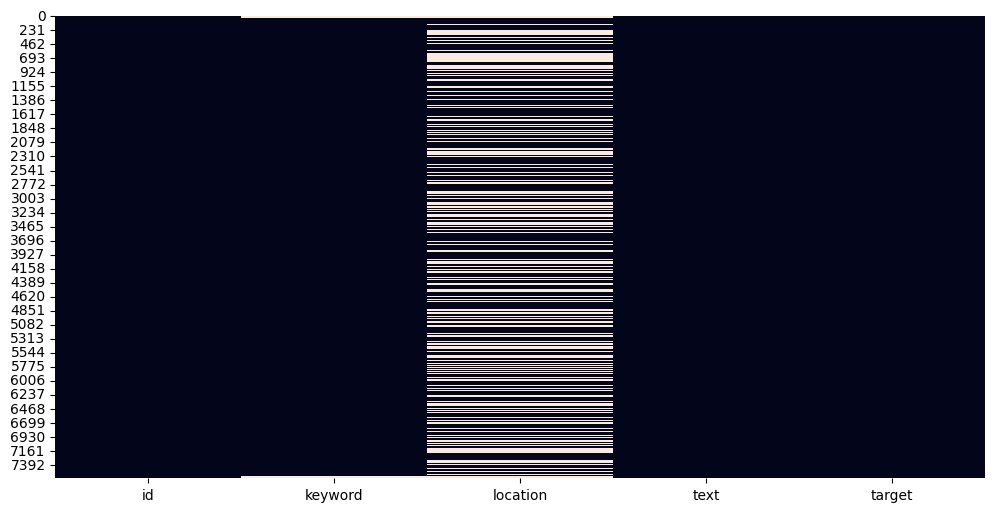

In [113]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.isna(), cbar=False)

In [114]:
nb_uniques = df["keyword"].nunique()  # nombre de mots-clés uniques (≠ valeurs nulles)
nb_non_nulls = df["keyword"].notnull().sum()  # cellules non vides
pourcentage_remplis = nb_non_nulls / len(df) * 100

print("Nombre de mots clés uniques :", nb_uniques)
print(f"Pourcentage de cellules remplies : {pourcentage_remplis:.2f}%")


Nombre de mots clés uniques : 221
Pourcentage de cellules remplies : 99.20%


In [115]:
nb_uniques = df["location"].nunique()
nb_non_nulls = df["location"].notnull().sum()
pourcentage_remplis = nb_non_nulls / len(df) * 100


print("Nombre de mots location uniques :", nb_uniques)
print(f"Pourcentage de cellules remplies : {pourcentage_remplis:.2f}%")


Nombre de mots location uniques : 3341
Pourcentage de cellules remplies : 66.73%


In [116]:
duplicate = df.duplicated().sum()  # nombre de doublons
print(f"Doublons :", duplicate)

Doublons : 0


In [117]:
df.drop_duplicates(inplace=True)  # suppression des doublons
print(f"Doublons après suppression :", df.duplicated().sum())

Doublons après suppression : 0


In [134]:
df = df.drop("id", axis=1)


In [119]:
print(df.shape)

(7613, 5)


In [120]:
df['target'].value_counts(normalize=True)

target
0    0.57034
1    0.42966
Name: proportion, dtype: float64

## Ajout features

In [121]:
# Nombre total de mots dans chaque tweet
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

# Nombre de stopwords (mots vides comme 'le', 'et', 'mais'...) dans chaque tweet
df['stop_word_count'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# Nombre de liens URL présents dans chaque tweet
df['url_count'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# Longueur moyenne des mots dans chaque tweet
df['mean_word_length'] = df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# Nombre total de caractères (lettres, espaces, ponctuations...) dans chaque tweet
df['char_count'] = df['text'].apply(lambda x: len(str(x)))

# Nombre de signes de ponctuation dans chaque tweet
df['punctuation_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# Nombre de hashtags (#) dans chaque tweet
df['hashtag_count'] = df['text'].apply(lambda x: str(x).count('#'))

# Nombre de mentions (@) dans chaque tweet
df['mention_count'] = df['text'].apply(lambda x: str(x).count('@'))

#Si location est présente, on marque 1, sinon 0
df['presence_location'] = df['location'].notnull().astype(int)

#Si keyword est présent, on marque 1, sinon 0
df['presence_keyword'] = df['keyword'].notnull().astype(int)

#Si location est présente, on marque 1, sinon 0
df['presence_url'] = df['url_count'].apply(lambda x: 1 if x > 0 else 0)

#Si location est présente, on marque 1, sinon 0
df['presence_mention'] = df['mention_count'].apply(lambda x: 1 if x > 0 else 0)



In [122]:
df.dtypes.value_counts()

int64      13
object      3
float64     1
Name: count, dtype: int64

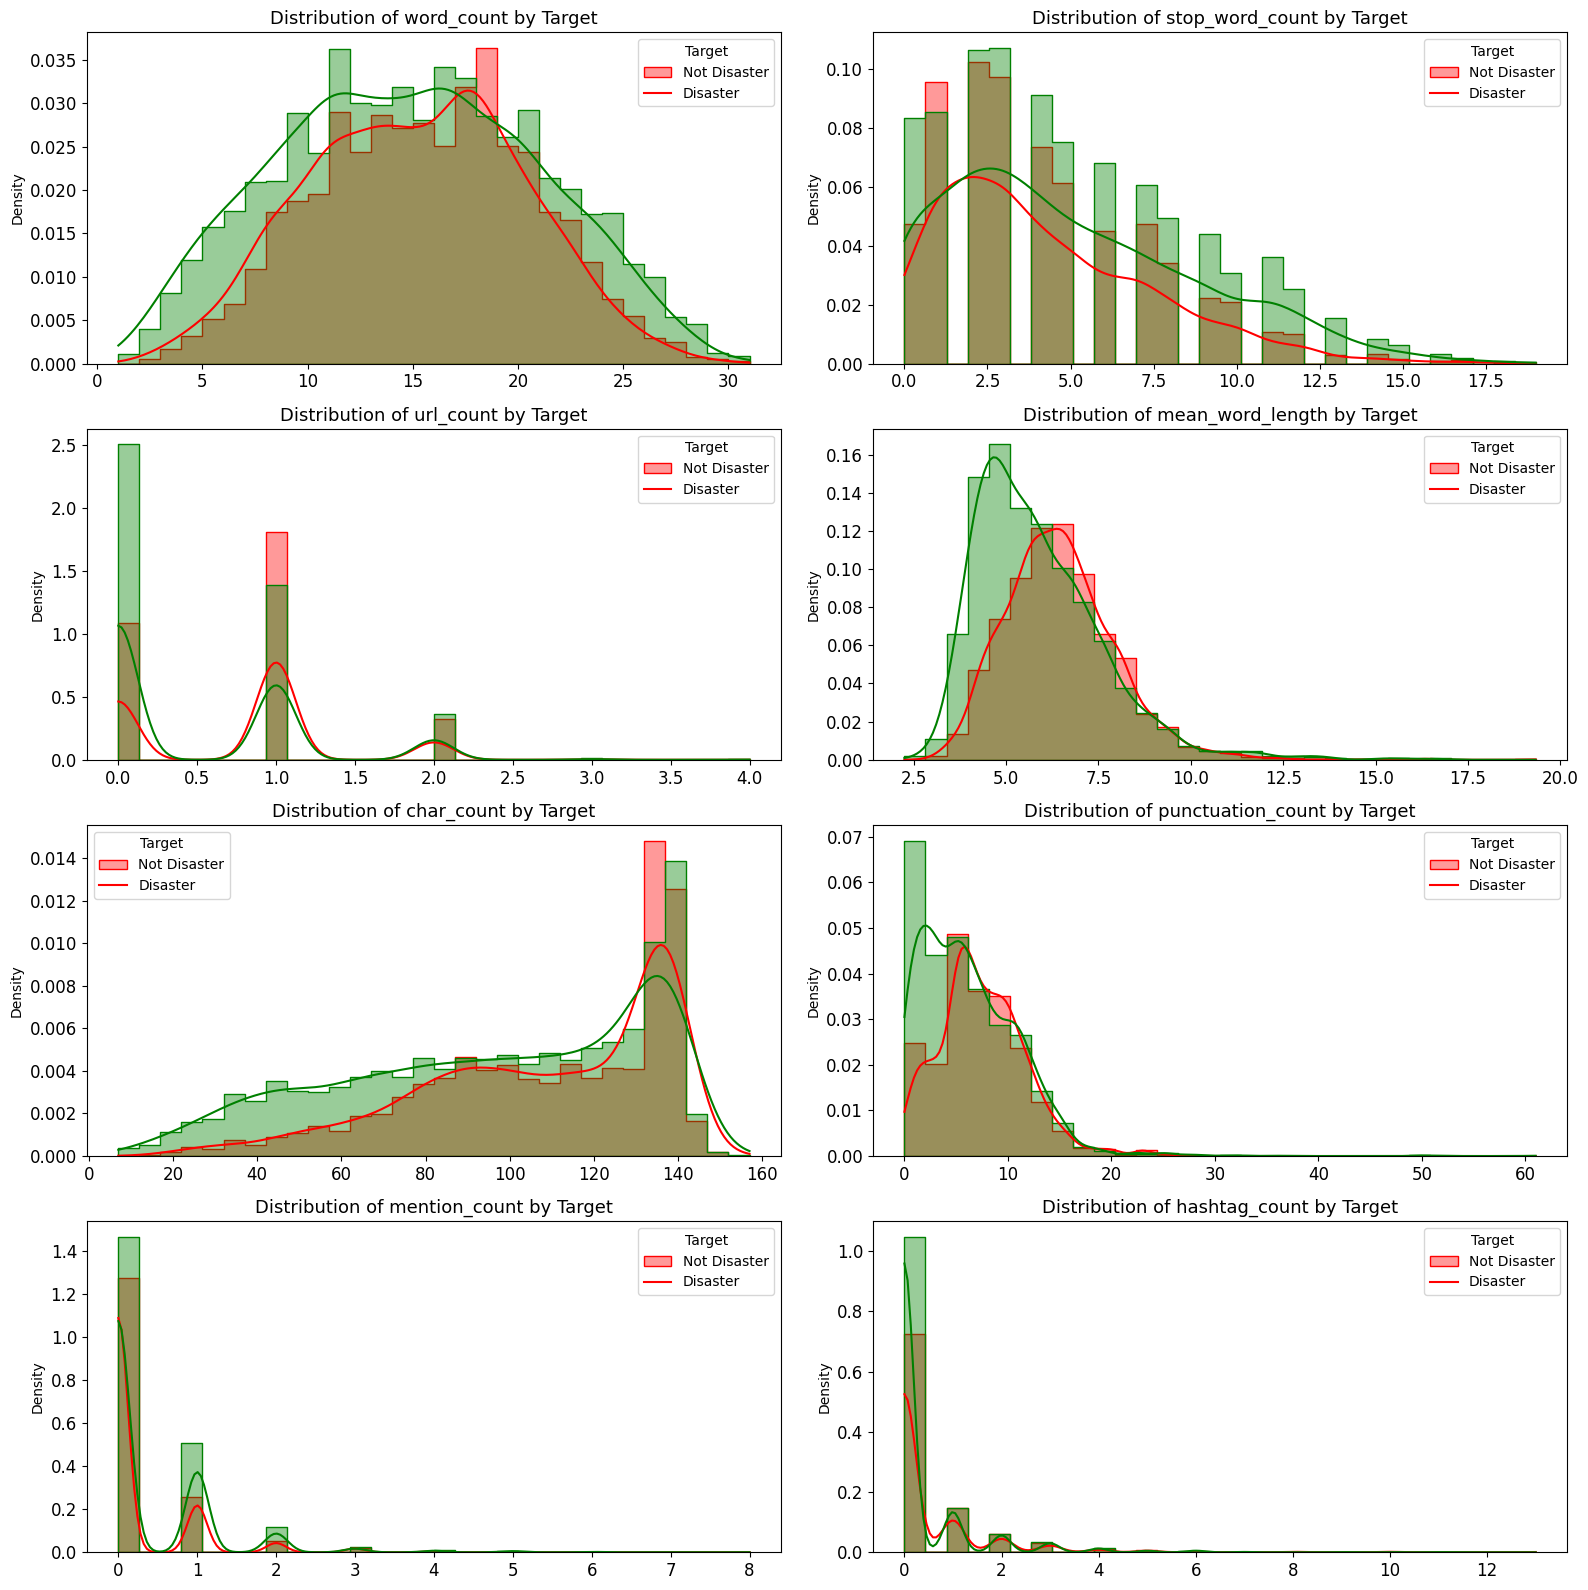

In [123]:
METAFEATURES = [
    'word_count', 'stop_word_count', 'url_count',
    'mean_word_length', 'char_count', 'punctuation_count', 'mention_count', 'hashtag_count',
]

nrows = (len(METAFEATURES) + 1) // 2  # 2 graphiques par ligne
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(16, 4 * nrows), dpi=100)
axes = axes.flatten()  # ✅ très important

for i, feature in enumerate(METAFEATURES):
    sns.histplot(data=df, x=feature, hue='target', ax=axes[i],
                 bins=30, kde=True, stat="density", element="step",
                 palette={0: 'green', 1: 'red'}, alpha=0.4)

    axes[i].set_title(f'Distribution of {feature} by Target', fontsize=13)
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)
    axes[i].legend(title='Target', labels=['Not Disaster', 'Disaster'])

# Supprimer les axes vides si le nombre de features est impair
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

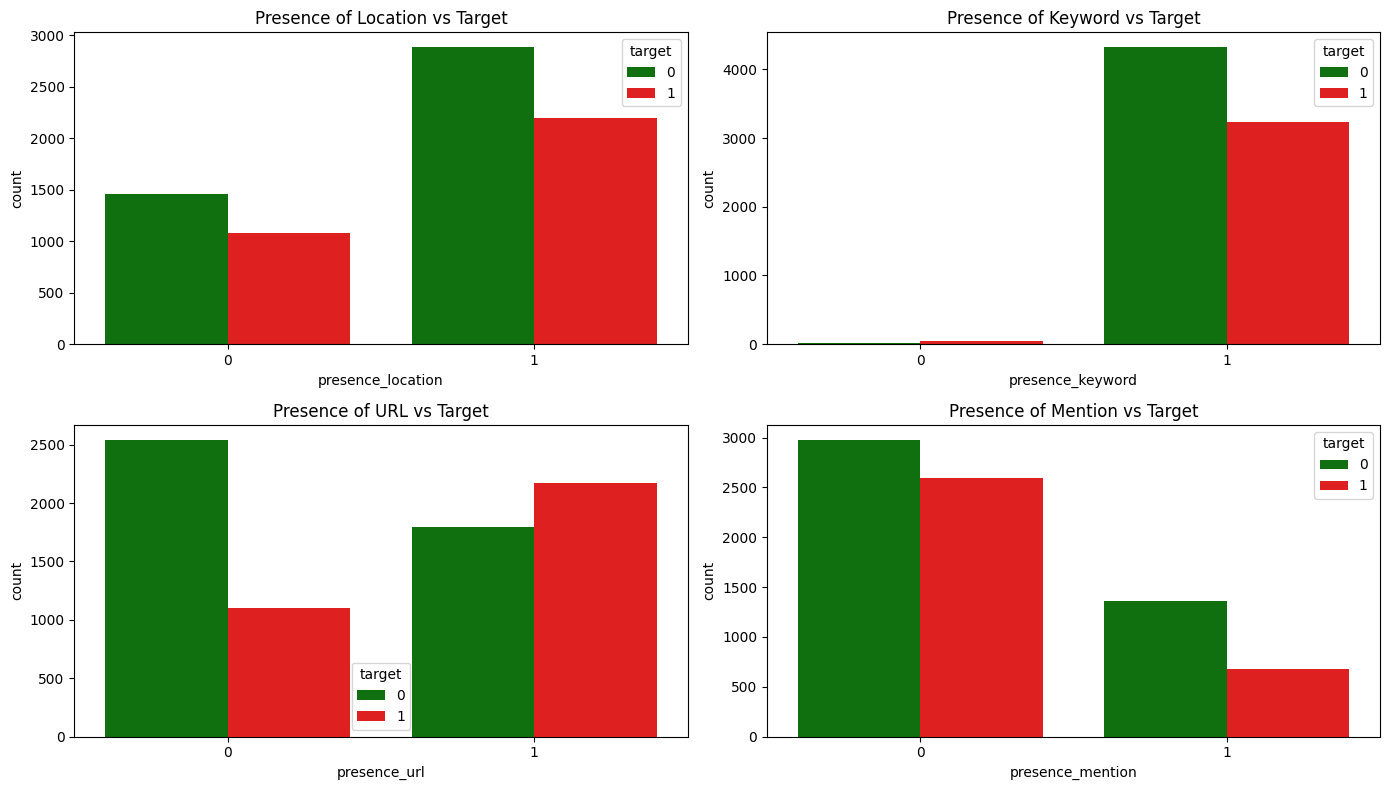

In [124]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))  # 2 lignes, 2 colonnes

# Liste des variables binaires à afficher
features = ['presence_location', 'presence_keyword', 'presence_url', 'presence_mention']
titles = ['Presence of Location', 'Presence of Keyword', 'Presence of URL', 'Presence of Mention']

# Boucle sur les 4 features et leur position dans la grille
for i, (feature, title) in enumerate(zip(features, titles)):
    row = i // 2
    col = i % 2
    sns.countplot(data=df, x=feature, hue='target', ax=axes[row][col], palette={0: 'green', 1: 'red'})
    axes[row][col].set_title(f"{title} vs Target")

plt.tight_layout()
plt.show()

In [125]:
# Sélection des colonnes numériques utiles (hors cible)
num_cols = df.select_dtypes(include='number').columns.drop('target')

# Statistiques descriptives globales, par classe 0 et par classe 1
desc_all = df[num_cols].describe().T
desc_neg = df[df['target'] == 0][num_cols].describe().T
desc_pos = df[df['target'] == 1][num_cols].describe().T

# Renommage des colonnes pour préciser l’origine
desc_all.columns = [f"{col}_all" for col in desc_all.columns]
desc_neg.columns = [f"{col}_neg" for col in desc_neg.columns]
desc_pos.columns = [f"{col}_pos" for col in desc_pos.columns]

# Fusion des 3 tableaux sur l’index (le nom des variables)
summary = desc_all.join(desc_neg).join(desc_pos)

# Affichage des colonnes clés : count et moyenne
summary = summary[[f"{stat}_{grp}" for stat in ["count", "mean"] for grp in ["all", "neg", "pos"]]]

summary


,count_all,count_neg,count_pos,mean_all,mean_neg,mean_pos
id,7613.0,4342.0,3271.0,5441.934848,5276.446338,5661.608071
word_count,7613.0,4342.0,3271.0,14.903586,14.704744,15.167533
stop_word_count,7613.0,4342.0,3271.0,4.672928,5.016582,4.216753
url_count,7613.0,4342.0,3271.0,0.620255,0.507600,0.769795
mean_word_length,7613.0,4342.0,3271.0,6.128494,5.871325,6.469866
char_count,7613.0,4342.0,3271.0,101.037436,95.706817,108.113421
punctuation_count,7613.0,4342.0,3271.0,6.839485,6.309074,7.543565
hashtag_count,7613.0,4342.0,3271.0,0.446999,0.391525,0.520636
mention_count,7613.0,4342.0,3271.0,0.362406,0.426992,0.276674
presence_location,7613.0,4342.0,3271.0,0.667280,0.664210,0.671354


In [126]:
df.drop(columns=['hashtag_count','mention_count','presence_location','presence_keyword', 'presence_mention'], inplace=True)  # Suppression des colonnes non numériques

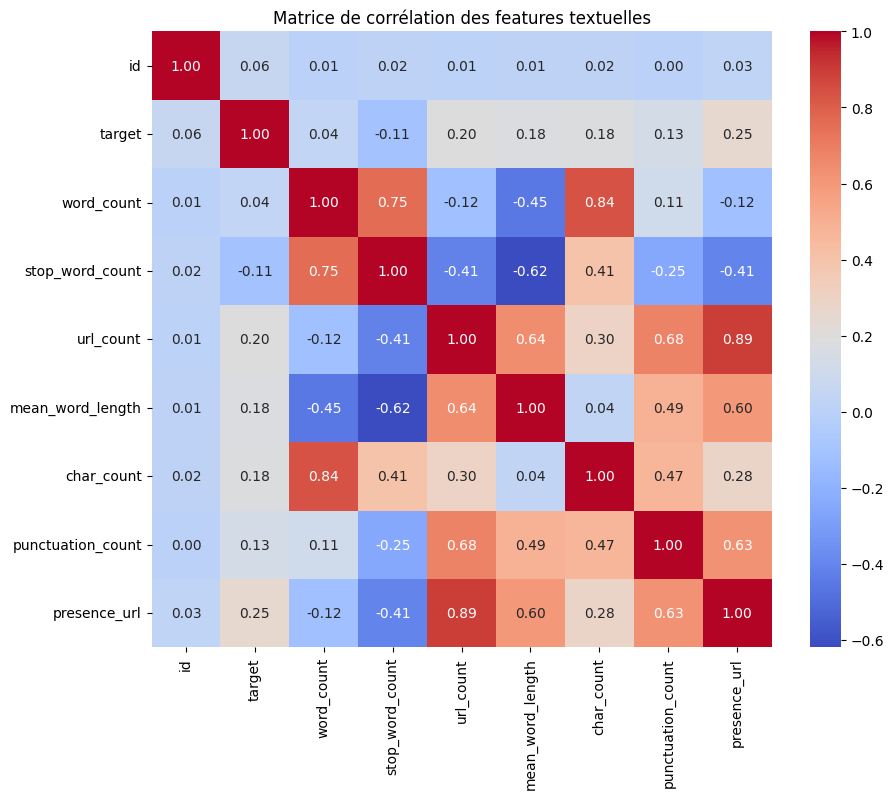

In [127]:
num_cols = df.select_dtypes(include='number').columns

corr_matrix = df[num_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation des features textuelles")
plt.show()

In [128]:
df.drop('presence_url', axis=1, inplace=True)

In [129]:
df.head()

,id,keyword,location,text,target,word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,6,0,4.384615,69,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,0,0,4.571429,38,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,11,0,5.090909,133,3
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,1,0,7.125000,65,2
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,7,0,4.500000,88,2


In [133]:
df.to_csv("../data/train_tweets_processed.csv", index=False)

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 7613 non-null   int64  
 1   keyword            7552 non-null   object 
 2   location           5080 non-null   object 
 3   text               7613 non-null   object 
 4   target             7613 non-null   int64  
 5   word_count         7613 non-null   int64  
 6   stop_word_count    7613 non-null   int64  
 7   url_count          7613 non-null   int64  
 8   mean_word_length   7613 non-null   float64
 9   char_count         7613 non-null   int64  
 10  punctuation_count  7613 non-null   int64  
 11  target_str         7613 non-null   object 
dtypes: float64(1), int64(7), object(4)
memory usage: 713.8+ KB
